In [1]:
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import rasterio
from rasterio.plot import show

print("Root directory:", os.getcwd())

Root directory: D:\RSCode\Cross-Modal-Learning


In [2]:
s2_folder = "D:\RSCode\BigEarthNet-S2"
s1_folder = "D:\RSCode\BigEarthNet-S1"

# Sentinel-1

The BigEarthNet-S1 directory has one directory per Sentinel-1 source tile (in total 312) and a
dedicated directory for each individual patch. Each patch directory contains the GeoTIFF files for
the individual bands.

In [3]:
s1_tiles = [folder for folder in os.listdir(s1_folder)] 
s1_tile_patches = [folder for folder in os.listdir(os.path.join(s1_folder, s1_tiles[0]))]

print("Number of tiles:", len(s1_tiles), "\nNumber of patches in a source tile:", len(s1_tile_patches))

Number of tiles: 312 
Number of patches in a source tile: 1699


VV Polarization (Vertical Transmit and Vertical Receive) is sensitive to vertically oriented structures and surfaces. For example, it responds well to flat surfaces like calm water bodies and canopies of trees or crops.

VH Polarization (Vertical Transmit and Horizontal Receive) is more sensitive to complex and rough surfaces that cause depolarization of the radar signal. It captures more information from surfaces that scatter the radar wave in multiple directions, such as vegetation, rough terrain, and heterogeneous surfaces.

In [4]:
s1_tiff_files = [file for file in os.listdir(os.path.join(s1_folder, s1_tiles[0], s1_tile_patches[0]))]
print(s1_tiff_files)

['S1A_IW_GRDH_1SDV_20170613T165043_33UUP_61_39_VH.tif', 'S1A_IW_GRDH_1SDV_20170613T165043_33UUP_61_39_VV.tif']


In [5]:
with rasterio.open(os.path.join(s1_folder, s1_tiles[0], s1_tile_patches[0], s1_tiff_files[0])) as src:
    sample_VH = src.read() 
with rasterio.open(os.path.join(s1_folder, s1_tiles[0], s1_tile_patches[0], s1_tiff_files[1])) as src:
    sample_VV = src.read() 

print("VV band shape: ", sample_VV.shape)
print("VH band shape: ", sample_VH.shape)

VV band shape:  (1, 120, 120)
VH band shape:  (1, 120, 120)


# Sentinel-2

The BigEarthNet-S2 directory has one directory per Sentinel-2 source tile (in total 115) and a
dedicated directory for each individual patch. Each patch directory contains the GeoTIFF files for
the individual bands.

In [6]:
s2_tiles = [folder for folder in os.listdir(s2_folder)] 
s2_tile_patches = [folder for folder in os.listdir(os.path.join(s2_folder, s2_tiles[0]))]

print("Number of tiles:", len(s2_tiles), "\nNumber of patches in a source tile:", len(s2_tile_patches))

Number of tiles: 115 
Number of patches in a source tile: 3305


In [7]:
s2_tiff_files = [file for file in os.listdir(os.path.join(s2_folder, s2_tiles[0], s2_tile_patches[0]))]

#https://gisgeography.com/sentinel-2-bands-combinations
band_resolutions = [60, 10, 10, 10, 20, 20, 20, 10, 60, 20, 20, 20] 

print('Band \t Resolution \n')
for i in range(len(s2_tiff_files)):
    print(s2_tiff_files[i][-7:-4], '\t', band_resolutions[i], 'm', '\n')

Band 	 Resolution 

B01 	 60 m 

B02 	 10 m 

B03 	 10 m 

B04 	 10 m 

B05 	 20 m 

B06 	 20 m 

B07 	 20 m 

B08 	 10 m 

B09 	 60 m 

B11 	 20 m 

B12 	 20 m 

B8A 	 20 m 



# Metadata Analysis

In [8]:
#!pip install pandas pyarrow
metadata_path = "D:\RSCode\metadata.parquet"

In [9]:
df = pd.read_parquet(metadata_path)

In [10]:
s2_corr_s1 = df[["patch_id", "s1_name", "labels", "split"]]
print("Number of Patches: " ,len(s2_corr_s1))
s2_corr_s1.head()

Number of Patches:  480038


,patch_id,s1_name,labels,split
0,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_26_57,"[Arable land, Broad-leaved forest, Mixed fores...",test
1,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_55,"[Arable land, Broad-leaved forest, Inland wate...",test
2,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_56,"[Arable land, Broad-leaved forest, Coniferous ...",test
3,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_57,"[Broad-leaved forest, Complex cultivation patt...",test
4,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_58,"[Broad-leaved forest, Complex cultivation patt...",test


In [11]:
s2_corr_s1['split'].unique()

array(['test', 'validation', 'train'], dtype=object)

In [12]:
s2_corr_s1 = s2_corr_s1[(s2_corr_s1["split"] == "train") | (s2_corr_s1["split"] == "test")]
print("Number of patches: " ,len(s2_corr_s1))
print(f'Training patches: {len(s2_corr_s1[s2_corr_s1["split"] == "train"])}\nTest patches: {len(s2_corr_s1[s2_corr_s1["split"] == "test"])}')

Number of patches:  357696
Training patches: 237871
Test patches: 119825


# Images

All of the patches in the table are suitable for scene classification. Work will be with a subset of the whole dataset and the corresponding patches of S2 and S1 datasets should be stacked together to create a 14 band data with the shape (14, 120, 120).

Sentinel-1 bands: (VV, VH)

Sentinel-2 bands: (B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12)

All bands: (VV, VH, B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12)

# Labels

19-class nomenclature

https://docs.kai-tub.tech/ben-docs/labels.html#id3



# Data Preprocessing

In [14]:
train_df = s2_corr_s1[s2_corr_s1["split"] == "train"]
test_df = s2_corr_s1[s2_corr_s1["split"] == "test"]

s2_tiles = [os.path.join(s2_folder, tile) for tile in s2_tiles]

In [15]:
def extract_tile_from_patch(patch):
    parts = patch.split('_')
    tile = '_'.join(parts[:-3])
    return tile

In [17]:
def min_max_of_bands(s2_patch_path, s1_patch_path, min_max_dict):
    
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + '_VV.tif')) as src:
        vv = src.read()
        vv_min = np.min(vv.squeeze())
        if vv_min < min_max_dict['vv_min']:
            min_max_dict['vv_min'] = vv_min
        vv_max = np.max(vv.squeeze())
        if vv_max > min_max_dict['vv_max']:
            min_max_dict['vv_max'] = vv_max
            
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + '_VH.tif')) as src:
        vh = src.read()
        vh_min = np.min(vh.squeeze())
        if vh_min < min_max_dict['vh_min']:
            min_max_dict['vh_min'] = vh_min
        vh_max = np.max(vh.squeeze())
        if vh_max > min_max_dict['vh_max']:
            min_max_dict['vh_max'] = vh_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B01.tif')) as src:
        b01 = src.read()
        b01_min = np.min(b01.squeeze())
        if b01_min < min_max_dict['b01_min']:
            min_max_dict['b01_min'] = b01_min
        b01_max = np.max(b01.squeeze())
        if b01_max > min_max_dict['b01_max']:
            min_max_dict['b01_max'] = b01_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B02.tif')) as src:
        b02 = src.read()
        b02_min = np.min(b02.squeeze())
        if b02_min < min_max_dict['b02_min']:
            min_max_dict['b02_min'] = b02_min
        b02_max = np.max(b02.squeeze())
        if b02_max > min_max_dict['b02_max']:
            min_max_dict['b02_max'] = b02_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B03.tif')) as src:
        b03 = src.read()
        b03_min = np.min(b03.squeeze())
        if b03_min < min_max_dict['b03_min']:
            min_max_dict['b03_min'] = b03_min
        b03_max = np.max(b03.squeeze())
        if b03_max > min_max_dict['b03_max']:
            min_max_dict['b03_max'] = b03_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B04.tif')) as src:
        b04 = src.read()
        b04_min = np.min(b04.squeeze())
        if b04_min < min_max_dict['b04_min']:
            min_max_dict['b04_min'] = b04_min
        b04_max = np.max(b04.squeeze())
        if b04_max > min_max_dict['b04_max']:
            min_max_dict['b04_max'] = b04_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B05.tif')) as src:
        b05 = src.read()
        b05_min = np.min(b05.squeeze())
        if b05_min < min_max_dict['b05_min']:
            min_max_dict['b05_min'] = b05_min
        b05_max = np.max(b05.squeeze())
        if b05_max > min_max_dict['b05_max']:
            min_max_dict['b05_max'] = b05_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B06.tif')) as src:
        b06 = src.read()
        b06_min = np.min(b06.squeeze())
        if b06_min < min_max_dict['b06_min']:
            min_max_dict['b06_min'] = b06_min
        b06_max = np.max(b06.squeeze())
        if b06_max > min_max_dict['b06_max']:
            min_max_dict['b06_max'] = b06_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B07.tif')) as src:
        b07 = src.read()
        b07_min = np.min(b07.squeeze())
        if b07_min < min_max_dict['b07_min']:
            min_max_dict['b07_min'] = b07_min
        b07_max = np.max(b07.squeeze())
        if b07_max > min_max_dict['b07_max']:
            min_max_dict['b07_max'] = b07_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B08.tif')) as src:
        b08 = src.read()
        b08_min = np.min(b08.squeeze())
        if b08_min < min_max_dict['b08_min']:
            min_max_dict['b08_min'] = b08_min
        b08_max = np.max(b08.squeeze())
        if b08_max > min_max_dict['b08_max']:
            min_max_dict['b08_max'] = b08_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B8A.tif')) as src:
        b8a = src.read()
        b8a_min = np.min(b8a.squeeze())
        if b8a_min < min_max_dict['b8a_min']:
            min_max_dict['b8a_min'] = b8a_min
        b8a_max = np.max(b8a.squeeze())
        if b8a_max > min_max_dict['b8a_max']:
            min_max_dict['b8a_max'] = b8a_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B09.tif')) as src:
        b09 = src.read()
        b09_min = np.min(b09.squeeze())
        if b09_min < min_max_dict['b09_min']:
            min_max_dict['b09_min'] = b09_min
        b09_max = np.max(b09.squeeze())
        if b09_max > min_max_dict['b09_max']:
            min_max_dict['b09_max'] = b09_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B11.tif')) as src:
        b11 = src.read()
        b11_min = np.min(b11.squeeze())
        if b11_min < min_max_dict['b11_min']:
            min_max_dict['b11_min'] = b11_min
        b11_max = np.max(b11.squeeze())
        if b11_max > min_max_dict['b11_max']:
            min_max_dict['b11_max'] = b11_max   
            
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B12.tif')) as src:
        b12 = src.read()
        b12_min = np.min(b12.squeeze())
        if b12_min < min_max_dict['b12_min']:
            min_max_dict['b12_min'] = b12_min
        b12_max = np.max(b12.squeeze())
        if b12_max > min_max_dict['b12_max']:
            min_max_dict['b12_max'] = b12_max   
            
    return min_max_dict

In [20]:
from tqdm import tqdm

In [ ]:
### Find the min max values of each band in the train dataset(first 40 sentinel2 tiles for sample batch).
min_max_dict = {}
min_max_dict['vv_min'],  min_max_dict['vv_max'] = np.inf, -np.inf
min_max_dict['vh_min'],  min_max_dict['vh_max'] = np.inf, -np.inf
min_max_dict['b01_min'], min_max_dict['b01_max'] = np.inf, -np.inf
min_max_dict['b02_min'], min_max_dict['b02_max'] = np.inf, -np.inf
min_max_dict['b03_min'], min_max_dict['b03_max'] = np.inf, -np.inf
min_max_dict['b04_min'], min_max_dict['b04_max'] = np.inf, -np.inf
min_max_dict['b05_min'], min_max_dict['b05_max'] = np.inf, -np.inf
min_max_dict['b06_min'], min_max_dict['b06_max'] = np.inf, -np.inf
min_max_dict['b07_min'], min_max_dict['b07_max'] = np.inf, -np.inf
min_max_dict['b08_min'], min_max_dict['b08_max'] = np.inf, -np.inf
min_max_dict['b8a_min'], min_max_dict['b8a_max'] = np.inf, -np.inf
min_max_dict['b09_min'], min_max_dict['b09_max'] = np.inf, -np.inf
min_max_dict['b11_min'], min_max_dict['b11_max'] = np.inf, -np.inf
min_max_dict['b12_min'], min_max_dict['b12_max'] = np.inf, -np.inf

for s2_tile in tqdm(s2_tiles[:40]): 
    for s2_patch in os.listdir(s2_tile):
        if s2_patch in train_df['patch_id'].values:
            patch_row = train_df.loc[train_df['patch_id'] == s2_patch]   #Find the corresponding s1 patch name
            s1_patch = patch_row['s1_name'].values[0]
            s1_tile = extract_tile_from_patch(s1_patch)                  #Find the path of the s1 patch
            s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
            s2_patch_path = os.path.join(s2_tile, s2_patch)              #Find the path of the s2 patch
            
            min_max_dict = min_max_of_bands(s2_patch_path, s1_patch_path, min_max_dict)
            

In [22]:
min_max_dict

{'vv_min': -66.079414,
 'vv_max': 34.60696,
 'vh_min': -75.111374,
 'vh_max': 29.472132,
 'b01_min': 1,
 'b01_max': 14533,
 'b02_min': 1,
 'b02_max': 20688,
 'b03_min': 1,
 'b03_max': 19072,
 'b04_min': 1,
 'b04_max': 17936,
 'b05_min': 1,
 'b05_max': 17403,
 'b06_min': 1,
 'b06_max': 16894,
 'b07_min': 1,
 'b07_max': 16645,
 'b08_min': 1,
 'b08_max': 16784,
 'b8a_min': 1,
 'b8a_max': 16340,
 'b09_min': 1,
 'b09_max': 15842,
 'b11_min': 1,
 'b11_max': 15452,
 'b12_min': 1,
 'b12_max': 15270}

In [23]:
# the dataset includes negative values, which indicates they are in db-scale. Should be normalized to [-1, 1] range.
# for normalization (no matter whether min-max or mean-stddev) the global values of the (train) dataset should be used.
def normalize_min_max(arr, min_val, max_val):
    return 2 * ((arr - min_val) / (max_val - min_val)) - 1

def normalize_mean_stddev(arr, mean_val, stddev_val):
    return (arr-mean) / std_dev

def normalize_to_rgb(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val)

# https://developers.google.com/earth-engine/datasets/catalog/TUBerlin_BigEarthNet_v1#bands
# the link above indicates that all bands should be scaled with 0.0001
def normalize_s2(arr):
    return arr / 10000

In [24]:
import scipy
from scipy.ndimage import zoom 

In [28]:
def combine_s2_s1_bands(s2_patch_path, s1_patch_path, min_max_dict):
    s1_s2_bands = []
    
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + '_VV.tif')) as src:
        raster_profile = src.profile
        vv = src.read()
        s1_s2_bands.append(normalize_min_max(vv.squeeze(), min_max_dict['vv_min'], min_max_dict['vv_max']))
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + '_VH.tif')) as src:
        vh = src.read()
        s1_s2_bands.append(normalize_min_max(vh.squeeze(), min_max_dict['vh_min'], min_max_dict['vh_max']))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B01.tif')) as src:
        b01 = src.read()
        b01 = zoom(normalize_min_max(b01.squeeze(), min_max_dict['b01_min'], min_max_dict['b01_max']), 6, order=1)
        s1_s2_bands.append(b01)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B02.tif')) as src:
        b02 = src.read()
        s1_s2_bands.append(normalize_min_max(b02.squeeze(), min_max_dict['b02_min'], min_max_dict['b02_max']))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B03.tif')) as src:
        b03 = src.read()
        s1_s2_bands.append(normalize_min_max(b03.squeeze(), min_max_dict['b03_min'], min_max_dict['b03_max']))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B04.tif')) as src:
        b04 = src.read()
        s1_s2_bands.append(normalize_min_max(b04.squeeze(), min_max_dict['b04_min'], min_max_dict['b04_max']))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B05.tif')) as src:
        b05 = src.read()
        b05 = zoom(normalize_min_max(b05.squeeze(), min_max_dict['b05_min'], min_max_dict['b05_max']), 2, order=1)
        s1_s2_bands.append(b05)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B06.tif')) as src:
        b06 = src.read()
        b06 = zoom(normalize_min_max(b06.squeeze(), min_max_dict['b06_min'], min_max_dict['b06_max']), 2, order=1)
        s1_s2_bands.append(b06)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B07.tif')) as src:
        b07 = src.read()
        b07 = zoom(normalize_min_max(b07.squeeze(), min_max_dict['b07_min'], min_max_dict['b07_max']), 2, order=1)
        s1_s2_bands.append(b07)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B08.tif')) as src:
        b08 = src.read()
        s1_s2_bands.append(normalize_min_max(b08.squeeze(), min_max_dict['b08_min'], min_max_dict['b08_max']))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B8A.tif')) as src:
        b8a = src.read()
        b8a = zoom(normalize_min_max(b8a.squeeze(), min_max_dict['b8a_min'], min_max_dict['b8a_max']), 2, order=1)
        s1_s2_bands.append(b8a)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B09.tif')) as src:
        b09 = src.read()
        b09 = zoom(normalize_min_max(b09.squeeze(), min_max_dict['b09_min'], min_max_dict['b09_max']), 6, order=1)
        s1_s2_bands.append(b09)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B11.tif')) as src:
        b11 = src.read()
        b11 = zoom(normalize_min_max(b11.squeeze(), min_max_dict['b11_min'], min_max_dict['b11_max']), 2, order=1)
        s1_s2_bands.append(b11)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B12.tif')) as src:
        b12 = src.read()
        b12 = zoom(normalize_min_max(b12.squeeze(), min_max_dict['b12_min'], min_max_dict['b12_max']), 2, order=1)
        s1_s2_bands.append(b12)
        
    s1_s2_bands = np.dstack(s1_s2_bands)
    s1_s2_bands = np.transpose(s1_s2_bands, [2,0,1])
    return s1_s2_bands, raster_profile

In [29]:
s1_s2_raster, _ = combine_s2_s1_bands('D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_00_39',
                                  'D:\RSCode\BigEarthNet-S1\S1A_IW_GRDH_1SDV_20170617T064724\S1A_IW_GRDH_1SDV_20170617T064724_29UPU_0_39', min_max_dict)

print("All Bands data shape: ", s1_s2_raster.shape, "\n")
print("Band ", "Min","\t", "Max","\t", "Mean")
print("VV: ", s1_s2_raster[0].min(), "\t", s1_s2_raster[0].max(), "\t", s1_s2_raster[0].mean())
print("VH: ", s1_s2_raster[1].min(), "\t", s1_s2_raster[1].max(), "\t", s1_s2_raster[1].mean())
print("RED:", s1_s2_raster[5].min(), "\t", s1_s2_raster[5].max(), "\t", s1_s2_raster[5].mean())

#https://gis.stackexchange.com/questions/400726/creating-composite-rgb-images-from-sentinel-1-channels
s1_rgb = np.dstack(np.array([s1_s2_raster[0], s1_s2_raster[1], s1_s2_raster[0] - s1_s2_raster[1]]))

#https://gisgeography.com/sentinel-2-bands-combinations
s2_rgb = np.dstack(np.array([s1_s2_raster[5], s1_s2_raster[4], s1_s2_raster[3]]))

All Bands data shape:  (14, 120, 120) 

Band  Min 	 Max 	 Mean
VV:  -0.18341290950775146 	 0.5601345300674438 	 0.05902830662412776
VH:  -0.18128061294555664 	 0.495039701461792 	 0.09201133594744736
RED: -0.9808196264287705 	 -0.6526345135210483 	 -0.9466339946721185


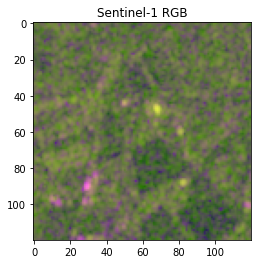

In [30]:
plt.imshow(normalize_to_rgb(s1_rgb))
plt.title("Sentinel-1 RGB")
plt.show()

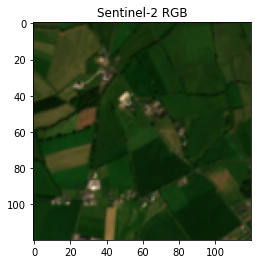

In [31]:
plt.imshow(normalize_to_rgb(s2_rgb))
plt.title("Sentinel-2 RGB")
plt.show()

In [33]:
train_folder = 'D:\RSCode\Train_dataset\images'
test_folder = 'D:\RSCode\Test_dataset\images'

In [35]:
for s2_tile in s2_tiles[:40]: 
    for s2_patch in os.listdir(s2_tile):
        if s2_patch in train_df['patch_id'].values:
            patch_row = train_df.loc[train_df['patch_id'] == s2_patch]   #Find the corresponding s1 patch name
            s1_patch = patch_row['s1_name'].values[0]
            s1_tile = extract_tile_from_patch(s1_patch)                  #Find the path of the s1 patch
            s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
            s2_patch_path = os.path.join(s2_tile, s2_patch)              #Find the path of the s2 patch
            
            s1_s2_raster, raster_profile = combine_s2_s1_bands(s2_patch_path, s1_patch_path, min_max_dict)
            
            output_path = os.path.join(train_folder, s2_patch + '.tif')
            profile = raster_profile.copy()
            profile.update({
                'driver': 'GTiff',
                'dtype': s1_s2_raster.dtype,
                'count': s1_s2_raster.shape[0],  # number of bands
                'height': s1_s2_raster.shape[1],
                'width': s1_s2_raster.shape[2],
            })

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(s1_s2_raster)

        elif s2_patch in test_df['patch_id'].values:
            patch_row = test_df.loc[test_df['patch_id'] == s2_patch]
            s1_patch = patch_row['s1_name'].values[0]
            s1_tile = extract_tile_from_patch(s1_patch)
            s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
            s2_patch_path = os.path.join(s2_tile, s2_patch)
            
            s1_s2_raster, raster_profile = combine_s2_s1_bands(s2_patch_path, s1_patch_path, min_max_dict)
            output_path = os.path.join(test_folder, s2_patch + '.tif')
            profile = raster_profile.copy()
            profile.update({
                'driver': 'GTiff',
                'dtype': s1_s2_raster.dtype,
                'count': s1_s2_raster.shape[0],  
                'height': s1_s2_raster.shape[1],
                'width': s1_s2_raster.shape[2],
            })

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(s1_s2_raster)
        

In [46]:
train_files = os.listdir(train_folder)
test_files = os.listdir(test_folder)
print("Train files count: ", len(train_files))
print("Test files count: ", len(test_files))

with rasterio.open(os.path.join(train_folder, train_files[55000])) as src:
    sample = src.read()
    print("Shape: ", sample.shape)
    s1_rgb = np.dstack(np.array([sample[0], sample[1], sample[0] - sample[1]]))
    s2_rgb = np.dstack(np.array([sample[5], sample[4], sample[3]]))

Train files count:  88417
Test files count:  47076
Shape:  (14, 120, 120)


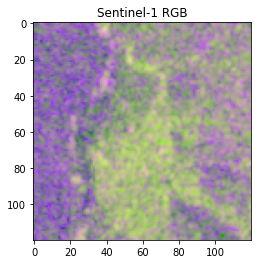

In [47]:
plt.imshow(normalize_to_rgb(s1_rgb))
plt.title("Sentinel-1 RGB")
plt.show()

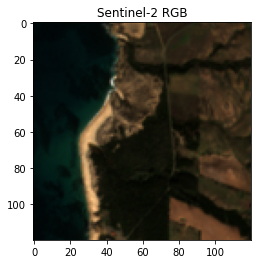

In [48]:
plt.imshow(normalize_to_rgb(s2_rgb))
plt.title("Sentinel-2 RGB")
plt.show()

In [42]:
def create_labels_df(file_list, df):
    
    result = []

    for tif_file in file_list:
        matching_row = df[df['patch_id'] == tif_file[:-4]]

        if not matching_row.empty:
            labels = matching_row.iloc[0]['labels']
            s1_name = matching_row.iloc[0]['s1_name']
            file_dict = {'s2_name': tif_file,
                         's1_name': s1_name}
            for label in labels:
                file_dict[label] = 1
            result.append(file_dict)
            
    result_df = pd.DataFrame(result)
    return result_df

In [43]:
train_labels_df = create_labels_df(train_files, train_df)
numeric_columns = train_labels_df.select_dtypes(include=['number']).columns
train_labels_df[numeric_columns] = train_labels_df[numeric_columns].fillna(0).astype(int)

test_labels_df = create_labels_df(test_files, test_df)
test_labels_df[numeric_columns] = test_labels_df[numeric_columns].fillna(0).astype(int)

In [44]:
test_labels_df.head()

,s2_name,s1_name,Arable land,Broad-leaved forest,Mixed forest,Pastures,Inland waters,Coniferous forest,Complex cultivation patterns,"Land principally occupied by agriculture, with significant areas of natural vegetation",...,Industrial or commercial units,Inland wetlands,"Transitional woodland, shrub",Marine waters,Coastal wetlands,"Moors, heathland and sclerophyllous vegetation",Natural grassland and sparsely vegetated areas,Permanent crops,"Beaches, dunes, sands",Agro-forestry areas
0,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_26_57,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_55,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_56,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_57,0,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_58,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [45]:
output_csv_path = 'D:\RSCode\Train_dataset\labels.csv'
train_labels_df.to_csv(output_csv_path, index=False)

output_csv_path = 'D:\RSCode\Test_dataset\labels.csv'
test_labels_df.to_csv(output_csv_path, index=False)